In [102]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn

In [103]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [104]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8)

In [105]:
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, "", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, "", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@0000018394E5B2A0) BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}

Naive Bayes sem dados de treino

In [106]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}' 
  
  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [126]:
conections

'cid10_faixa{F10-F19|F60-F69|F30-F39|F70-F79|F20-F29|F01-F09|F40-F49|F90-F98|F99-F99|F50-F59|F80-F89}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};cid10_seg_faixa{Sem|F60-F69|F10-F19|F30-F39|F20-F29|F01-F09|F70-F79|F40-F49|F50-F59|F90-F98|F80-F89|F99-F99}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};sexo{F|M|T}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};faixa_etaria{40-49|30-39|60-69|15-19|20-29|50-59|Sem|10-14|70-79|0-9|>80}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};etnia{BRANCO|PARDO|NEGRO|NAO INFORMADO|AMARELO}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};qtd_internacoes{8|4|2|3|5|12|13|1|6|15|7|10|18|14|9|20|16|17|11}<-cid10_faixa_alta{F10-F19|F60-F69|F

Naive Bayes com dados de treino

In [107]:
learner = gum.BNLearner(df_train, bn)
bn1 = learner.learnParameters(bn.dag())
bn1

(pyAgrum.BayesNet<double>@0000018394E68F80) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

Rede encontrada a partir dos dados de treino

In [108]:
learner = gum.BNLearner(df_train, template)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@0000018394E63E20) BN{nodes: 14, arcs: 15, domainSize: 10^9.85975, dim: 512, mem: 4Ko 704o}

Rede encontrada a partir dos dados de treino com conexões obrigatórias

In [109]:
learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn3 = learner.learnBN()
bn3

(pyAgrum.BayesNet<double>@0000018394E66CA0) BN{nodes: 14, arcs: 17, domainSize: 10^9.85975, dim: 4646, mem: 39Ko 936o}

Classificador

In [110]:
import pyAgrum.skbn as skbn

In [111]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [112]:
scoreAll = pd.DataFrame()

Naive Bayes sem treinamento

In [113]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes sem treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F70-F79', 'F60-F69', 'F70-F79', 'F99-F99', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F60-F69', 'F70-F79', 'F70-F79', 'F70-F79', 'F30-F39', 'F01-F09', 'F70-F79', 'F70-F79', 'F50-F59', 'F99-F99', 'F30-F39', 'F70-F79', 'F30-F39', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F20-F29', 'F70-F79', 'F20-F29', 'F70-F79', 'F40-F49', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F90-F98', 'F70-F79', 'F50-F59', 'F70-F79', 'F50-F59', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F90-F98', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F99-F99', 'F50-F59', 'F70-F79', 'F70-F79', 'F70-F79', 'F40-F49', 'F70-F79', 'F70-F79', 'F70-F79', 'F01-F09', 'F70-F79', 'F70-F79', 'F70-F79', 'F70-F79', 'F60-F69', 'F70-F79', 'F70-F79', 'F20-F29', 'F90-F98

Naive Bayes com treinamento

In [114]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn1,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes com treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F01-F09', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F01-F09', 'F30-F39', 'F10-F19', 'F20-F29', 'F10-F19', 'F60-F69', 'F60-F69', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29

Rede econtrada pelo treinamento

Binary classifier : False


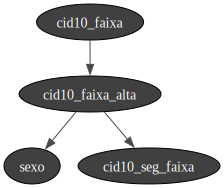

predicted : ['F10-F19', 'F70-F79', 'F10-F19', 'F20-F29', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F01-F09', 'F10-F19', 'F20-F29', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F01-F09', 'F30-F39', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29

In [115]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn2,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede econtrada pelo treinamento'] = pd.Series(scoreCSV1)

Rede encontrada pelo treinamento, com conexões obrigatórias

Binary classifier : False


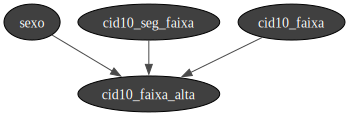

predicted : ['F10-F19', 'F70-F79', 'F10-F19', 'F20-F29', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F01-F09', 'F10-F19', 'F20-F29', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F01-F09', 'F30-F39', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29

In [116]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn3,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento, com conexões obrigatórias'] = pd.Series(scoreCSV1)

In [117]:
scoreAll

,Naive Bayes sem treinamento,Naive Bayes com treinamento,Rede econtrada pelo treinamento,"Rede encontrada pelo treinamento, com conexões obrigatórias"
0,0.056569,0.698905,0.723844,0.729319


bayesian_data/X_test.csv:   0%|          |

bayesian_data/X_test.csv: 100%|██████████|


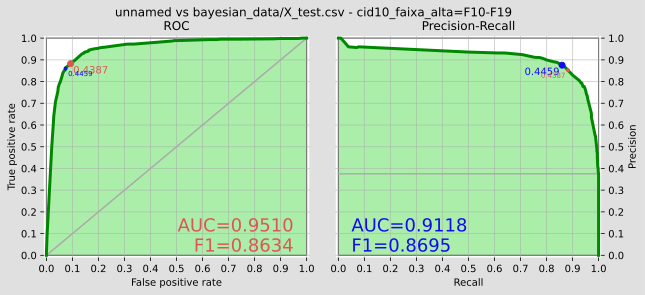

(0.9509554823651204, 0.4387171605, 0.9118062541063198, 0.44590533275)

In [125]:
from pyAgrum.lib.bn2roc import showROC_PR
showROC_PR(bn3, "bayesian_data/X_test.csv", 'cid10_faixa_alta', "F10-F19", show_progress=True, show_fig=True)